# Mapping of soil organic carbon stocks with Random Forest

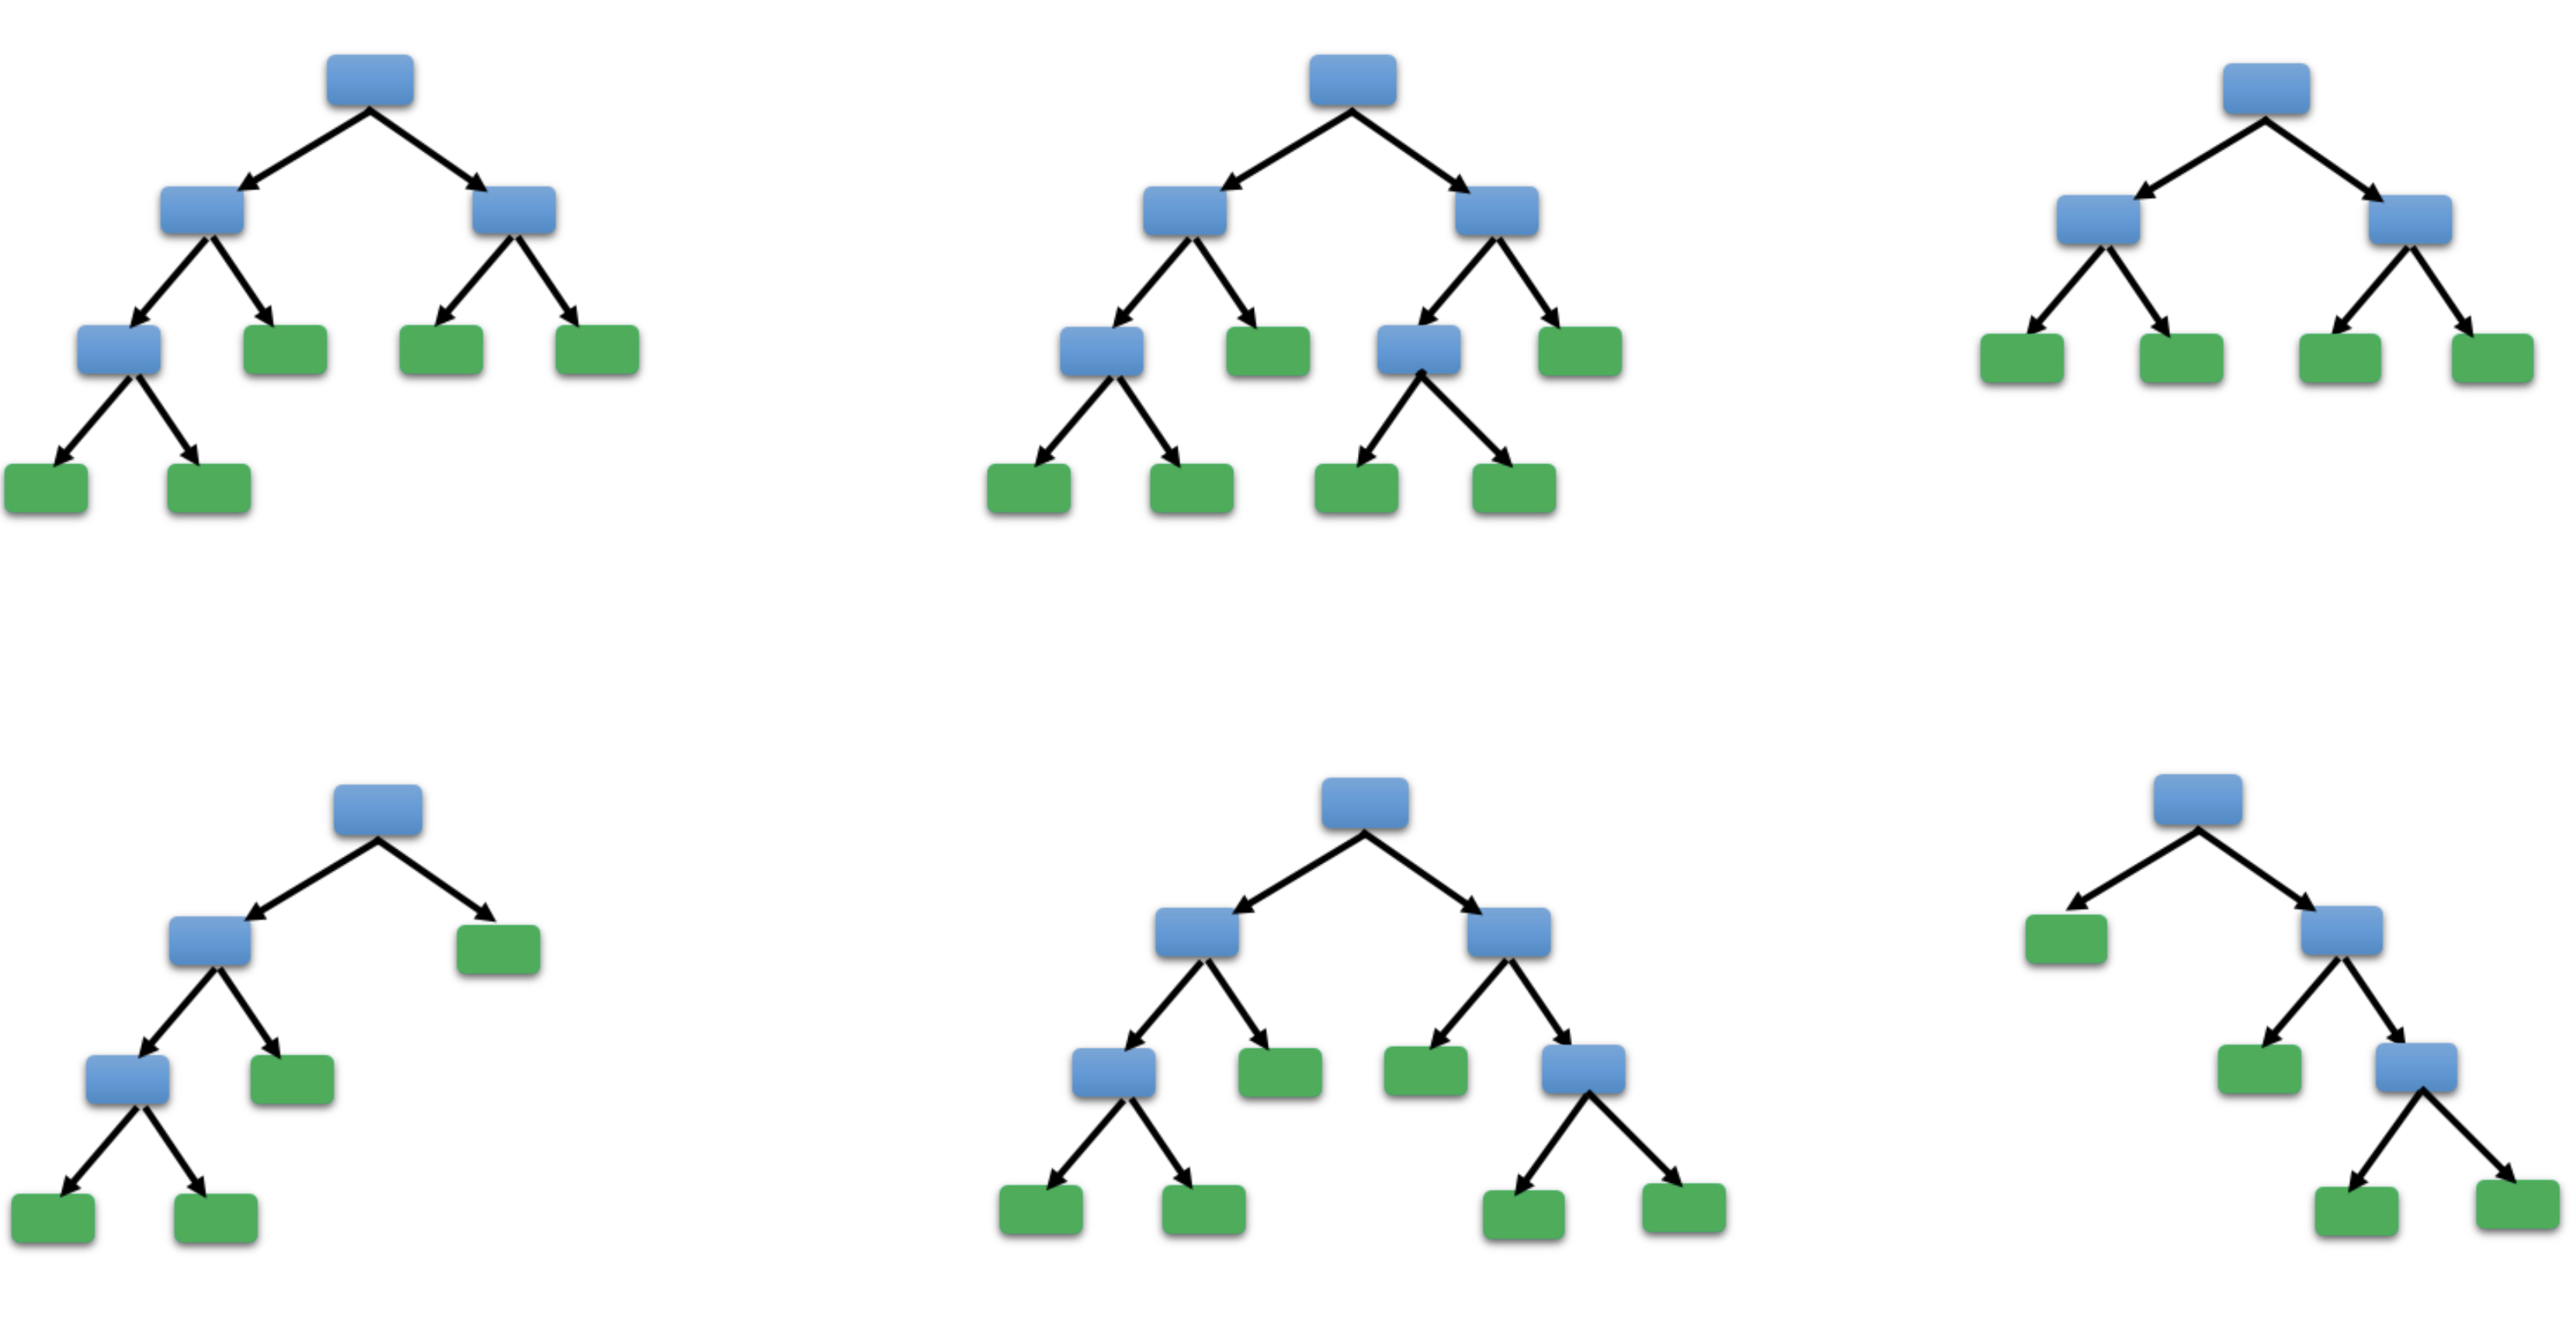

In [27]:
from IPython.display import Image
Image(filename="Screenshots_Images/forest.png", width = 300, height = 150)

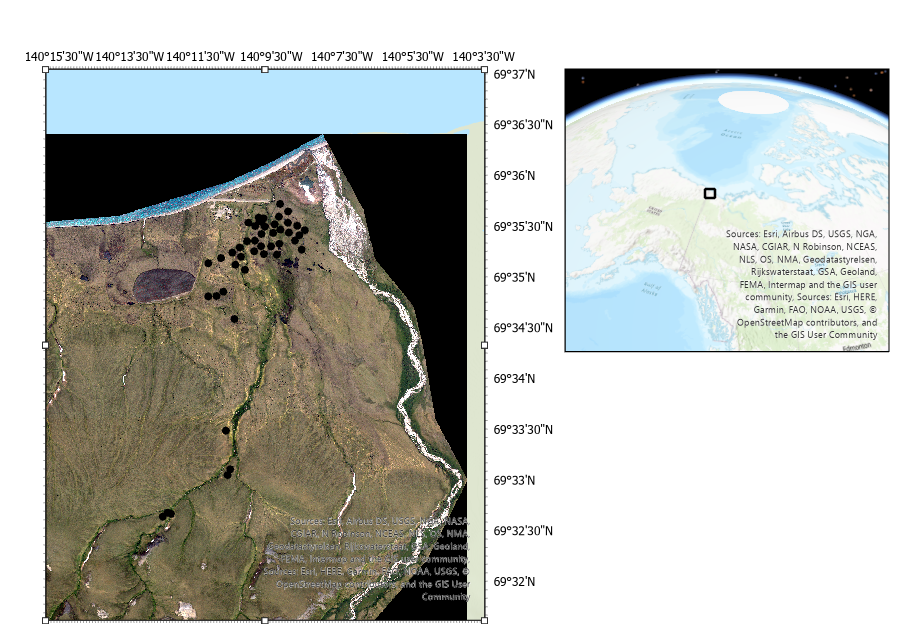

In [38]:
from IPython.display import Image
Image(filename="Screenshots_Images/Overview.PNG", width = 800, height = 800)

## Preprocessing (Bash)

### Calculating DEM Derivates from Arctic DEM 


In [6]:
%%bash 
cd /home/julia/Documents/Project_course
pwd

/home/julia/Documents/Project_course


In [ ]:
#calculate terrain parameters using SAGA GIS
%%bash 
for f in *.tif; do 
	echo "Processing $f file..."
	
	#convert to grd
	gdal_translate  $f filled$f.grd

	# fill sinks
	saga_cmd ta_preprocessor 4 -ELEV ${f}.grd -FILLED filled${f}.grd

	#calculate slope aspect curvature
	saga_cmd ta_morphometry 0 -ELEVATION filled$f.grd -SLOPE slope$f.grd -ASPECT aspect$f.grd  -C_GENE curv$f.grd -C_PROF prof_curv$f.grd -C_PLAN plan_curv$f.grd

	#calculate flow path length
	saga_cmd ta_hydrology 6 -ELEVATION  filled$f.grd  -LENGTH flplength$f.grd


	#Flow Accumulation
	saga_cmd ta_hydrology 0 -ELEVATION filled$f.grd  -FLOW flowacc$f.grd

	#LS Factor 
	saga_cmd ta_hydrology 22 -SLOPE slope$f.sgrd -AREA flowacc$f.sgrd -LS LSfactor$f.grd 


	#Channel Network 
	saga_cmd ta_channels 0 -ELEVATION filled$f.grd -INIT_GRID flowacc$f.sgrd -INIT_METHOD 2 -INIT_VALUE 400000 -CHNLNTWRK channelnetwork$f.grd -CHNLROUTE channelroute$f.grd

	#Vertical dist channel netw
	saga_cmd ta_channels 3 -ELEVATION filled$f.grd -CHANNELS channelnetwork$f.sgrd -DISTANCE vertdistchnetw$f.sgrd

	#TWI 
	saga_cmd ta_hydrology 20 -SLOPE slope$f.sgrd -AREA flowacc$f.sgrd -TWI TWI$f.grd

	#TCI low 
	saga_cmd ta_hydrology 24 -DISTANCE vertdistchnetw$f.sgrd -TWI TWI$f.sgrd -TCILOW TCIlow$f.grd


	#TPI (Topographic position index)
	saga_cmd ta_morphometry 18 -DEM filled$f.grd -TPI TPI$f.sgrd

	#TRI (Terrain ruggedness index)
	saga_cmd ta_morphometry 16 -DEM filled$f.grd -TRI TRI$f.sgrd
	
	
done

#convert to tif

for f in *.sgrd
do
  echo "Processing $f file..."
  saga_cmd io_gdal 1 -GRIDS $f -TYPE 6 -FORMAT 1 -FILE $f.tif
done



In [ ]:
#clip terrain parameters and DEM to processing extent using a mask that contains the extent (1) and the rest as nodata
%%bash 
cd /home/julia/Documents/Project_course/Terrain_parameter
for f in *.tif; 
do 
gdal_calc.py -A /home/julia/Documents/Project_course/YC19_Watershed_ArcticDEM/mask_1_nodata.tif -B $f --outfile=clip$f --calc="B*(A>0)"
done

#remove nodata using Module Crop to Data from SAGA-GIS and convert sgrd to tif
for f in *.tif; 
do 
saga_cmd grid_tools 17 -INPUT $f -OUTPUT area_$f
done

#converting sgrd to tif
for f in *.sgrd; 
do 
saga_cmd io_gdal 1 -GRIDS $f -TYPE 6 -FORMAT 1 -FILE $f.tif
done

## Training and prediction of Random Forest Model (R)

### Preparing training and prediction Datasets

In [10]:
###This is run in R #####

#load packages
library(dplyr)
library(raster)
library(terra)
library(caret)
library(mapview)
library(sf)
library(CAST)
library(tmap)
library(latticeExtra)
library(stars)

In [ ]:
#creating training and prediction datasets

#Import rasters as raster stack

rastlist <- list.files(path = "D:/Project_course/Terrain_parameter", pattern="*.tif$", all.files=TRUE, full.names=FALSE)
rastlist
rasters_stack <- terra::rast(paste0("D:/Project_course/Terrain_parameter/", rastlist))

#import training table

dsTrain <- read.csv(file = 'D:/Project_course/Train_Dataset/train_SOC_stocks_0-30.csv')
#train_shapefile <-  read_sf("D:/Project_course/Train_Dataset/SOC_stocks_0-30_coord.shp")

#convert to spatialpoints
dsTrain_sh <- st_as_sf(x = dsTrain, 
                        coords = c("X", "Y"),
                        crs = "EPSG:32607")

#visualization of points using the mapview package
mapview(dsTrain_sh) 
#visualization of rasters
plot(rasters_stack)

```

```{r}
#Point sampling of point values to raster
#(using vect() otherwise error)
#extr <- terra::extract(rasters_stack, vect(dsTrain_sh), df=TRUE)

#point ssmpling the values and appending them to the shapefile attribute table in one step
dsTrain_sh <- data.frame(dsTrain_sh, terra::extract(rasters_stack, vect(dsTrain_sh), cellnumbers=TRUE))

dfTrain <- as.data.frame(dsTrain_sh)

#removing irrelavant columns (coordinates, ID), keeping only Training parameters

dsTrain2Model <- dfTrain[,c(-1,-2,-4,-5,-6,-7,-9,-10)]

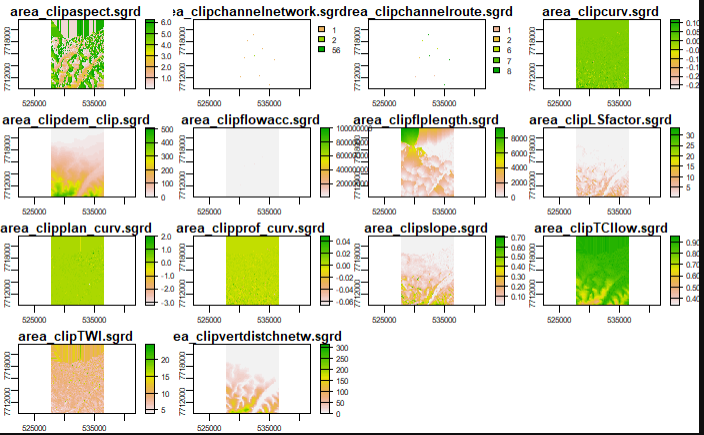

In [34]:
from IPython.display import Image
Image(filename="Screenshots_Images/input_var.PNG", width = 600, height = 400)

### Training of the Model

In [7]:
#Train model

set.seed(2021)

# defining the parameters: 3-fold crossvalidation
ctrl <- trainControl(method="cv", 
                     number=3,
                     savePredictions = FALSE)
# training the model
model <- train(dsTrain2Model[,c(-1)],dsTrain2Model$SOC.stocks, # training variables, target variable
               method="rf",tuneGrid = expand.grid(mtry = c(3:10)), # method: Random Forest, testing different mtry and use the mtry model with the best RMSE 
               importance=TRUE,ntree=500, # creating variable importance, creating 500 trees
               trControl=ctrl) 

#show properties of the model
model

#show which variables were most important for model
varImp(model)
plot(varImp(model))


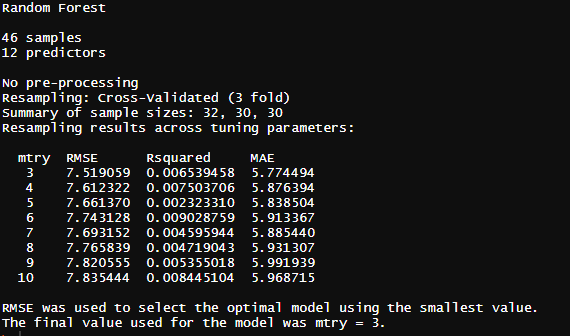

In [40]:
from IPython.display import Image
Image(filename="Screenshots_Images/model.PNG", width = 500, height = 500)

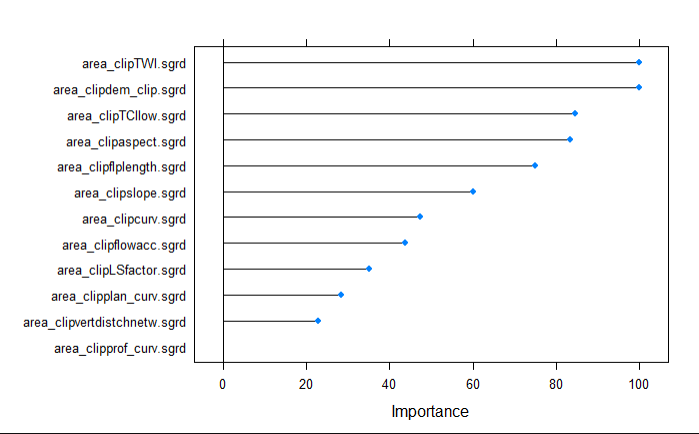

In [2]:

from IPython.display import Image
Image(filename="Screenshots_Images/varImp.PNG", width = 500, height = 500)

### Prediction of the Model 

In [ ]:
#prediction 

#Model prediction

prediction <- predict(rasters_stack,model)
plot(prediction)

#save prediction as tiff in working directory
writeRaster(prediction, 'prediction_C_0-30.tif')


### Clip prediction result to extent of the Catchment shapefile (Bash)

In [ ]:
%%bash
gdalwarp -dstnodata -9999 -cutline /home/julia/Documents/Project_course/YC19_Watershed_ArcticDEM/catchm_fix_geom.shp -crop_to_cutline -of GTiff prediction_C_030.tif clipped_c_030.tif

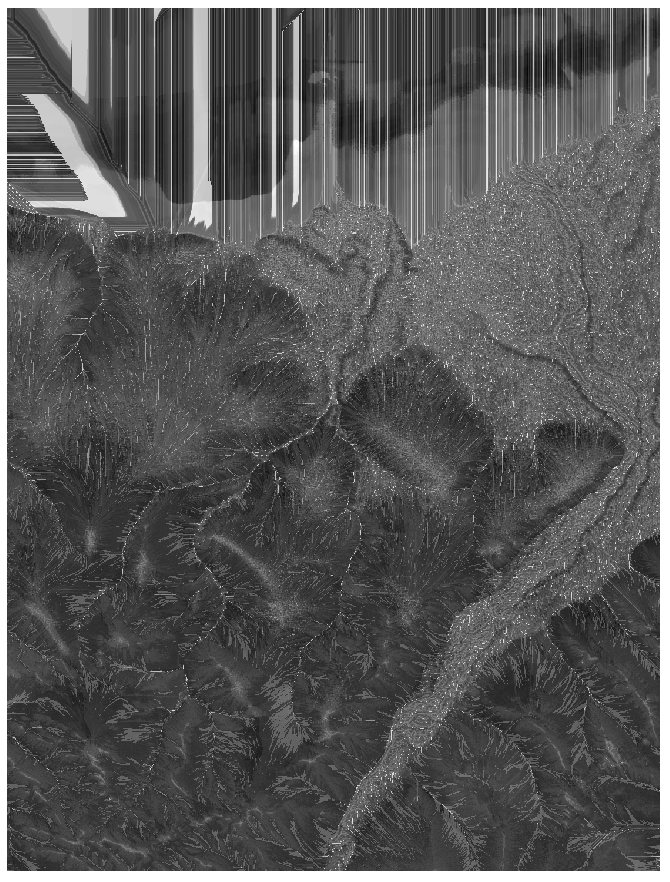

In [43]:
from IPython.display import Image
Image(filename="Screenshots_Images/prediction.PNG", width = 300, height = 300)

Prediction: bright pixels represent high values and dark pixels low values. 

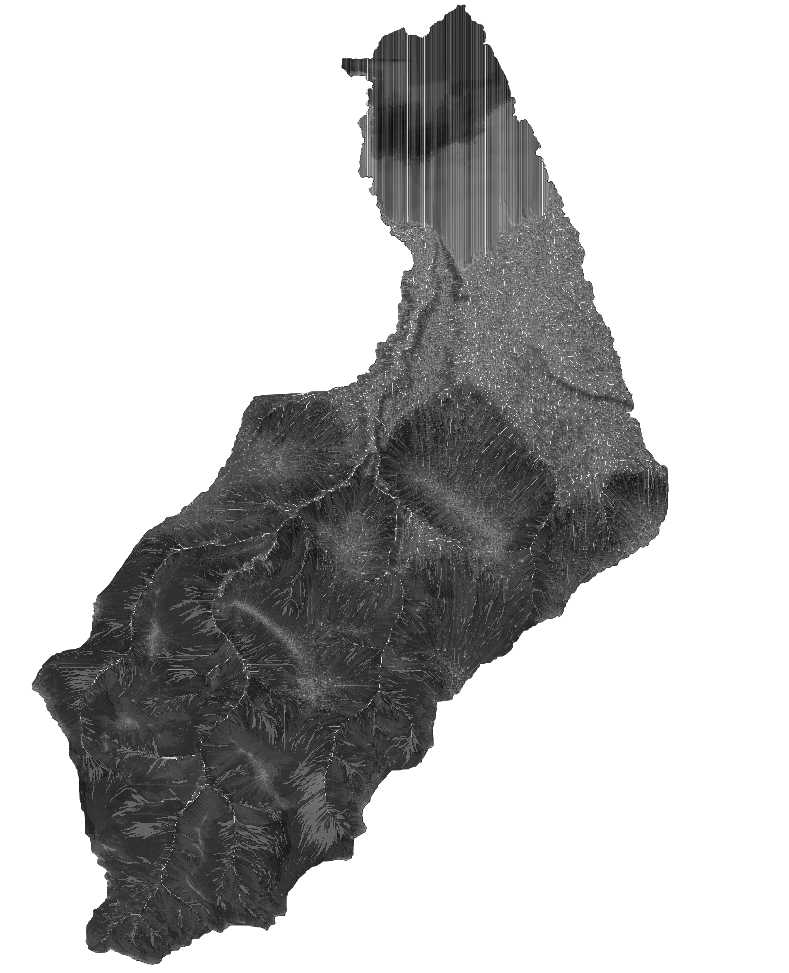

In [1]:
from IPython.display import Image
Image(filename="Screenshots_Images/Catchment.png", width = 300, height = 300)